# Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

# Standard library
from pathlib import Path
import pprint

# Third-party libraries
import duckdb
import fireducks.pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import optuna
import plotly.graph_objects as go
from matplotlib import rcParams
from sklearn.covariance import EmpiricalCovariance

rcParams["text.usetex"] = True

# Custom osbad library for anomaly detection
import osbad.config as bconf
import osbad.hyperparam as hp
import osbad.modval as modval
import osbad.stats as bstats
import osbad.viz as bviz
from osbad.database import BenchDB
from osbad.scaler import CycleScaling
from osbad.model import ModelRunner

# Import dataset

## Define filepath here

In [2]:
# Define a global variable to save fig output
# The definition of PIPELINE_OUTPUT_DIR can be
# found in config.py
PIPELINE_OUTPUT_DIR = bconf.PIPELINE_OUTPUT_DIR

In [3]:
# Path to the DuckDB instance:
# "tohoku_benchmark_dataset.db" inside the database folder
db_filepath = (
    Path.cwd()
    .parent.parent.parent
    .joinpath("database","tohoku_benchmark_dataset.db"))

## Get the cell inventory of the training dataset

In [4]:
# Create a DuckDB connection
con = duckdb.connect(
    db_filepath,
    read_only=True)

# Load all training dataset from duckdb
df_duckdb = con.sql(
    "SELECT * FROM df_tohoku_dataset").df()

# Drop the additional index column
df_duckdb = df_duckdb.drop(
    columns="__index_level_0__",
    errors="ignore")

# Get the cell index of training dataset
unique_cell_index_train = df_duckdb["cell_index"].unique()
print(f"Unique cell index: {unique_cell_index_train}")

Unique cell index: ['cell_num_1' 'cell_num_2' 'cell_num_3' 'cell_num_4' 'cell_num_5'
 'cell_num_6' 'cell_num_7' 'cell_num_8' 'cell_num_9' 'cell_num_10']


In [5]:
df_duckdb

,discharge_capacity,voltage,cycle_index,cell_index,outlier
0,0.000077,3.617995,0,cell_num_1,0
1,0.231343,3.572679,0,cell_num_1,0
2,0.462615,3.567599,0,cell_num_1,0
3,0.693891,3.563376,0,cell_num_1,0
4,0.925169,3.559585,0,cell_num_1,0
...,...,...,...,...,...
905544,38.371162,3.074328,239,cell_num_10,1
905545,38.602310,3.072911,239,cell_num_10,1
905546,38.833466,3.071518,239,cell_num_10,1
905547,39.064613,3.070054,239,cell_num_10,1


## Filtered dataset for selected cell only

In [6]:
# Get the cell-ID from cell_inventory
selected_cell_label = "cell_num_1"
cell_num = selected_cell_label[-1]

# Create a subfolder to store fig output
# corresponding to each cell-index
selected_cell_artifacts_dir = bconf.artifacts_output_dir(
    selected_cell_label)

# Filter dataset for specific selected cell only
df_selected_cell = df_duckdb[
    df_duckdb["cell_index"] == selected_cell_label]

# Import the BenchDB class
benchdb = BenchDB(
    db_filepath,
    selected_cell_label)

In [7]:
# Filter dataset for specific selected cell only
df_selected_cell = df_duckdb[
    df_duckdb["cell_index"] == selected_cell_label]

## Drop labels

In [8]:
# Drop the outlier labels
df_selected_cell_without_labels = df_selected_cell.drop(
    "outlier", axis=1).reset_index(drop=True)

df_selected_cell_without_labels   

,discharge_capacity,voltage,cycle_index,cell_index
0,0.000077,3.617995,0,cell_num_1
1,0.231343,3.572679,0,cell_num_1
2,0.462615,3.567599,0,cell_num_1
3,0.693891,3.563376,0,cell_num_1
4,0.925169,3.559585,0,cell_num_1
...,...,...,...,...
158807,37.700096,3.067416,476,cell_num_1
158808,37.931385,3.066397,476,cell_num_1
158809,38.162678,3.065279,476,cell_num_1
158810,38.393963,3.064079,476,cell_num_1


## Plot cycle capacity fade without labels

In [9]:
# Calculate maximum capacity per cycle
max_cap_per_cycle = (
    df_selected_cell_without_labels
        .groupby(["cycle_index"])["discharge_capacity"].max())
max_cap_per_cycle.name = "max_discharge_capacity"

unique_cycle_index = (
    df_selected_cell_without_labels["cycle_index"].unique())

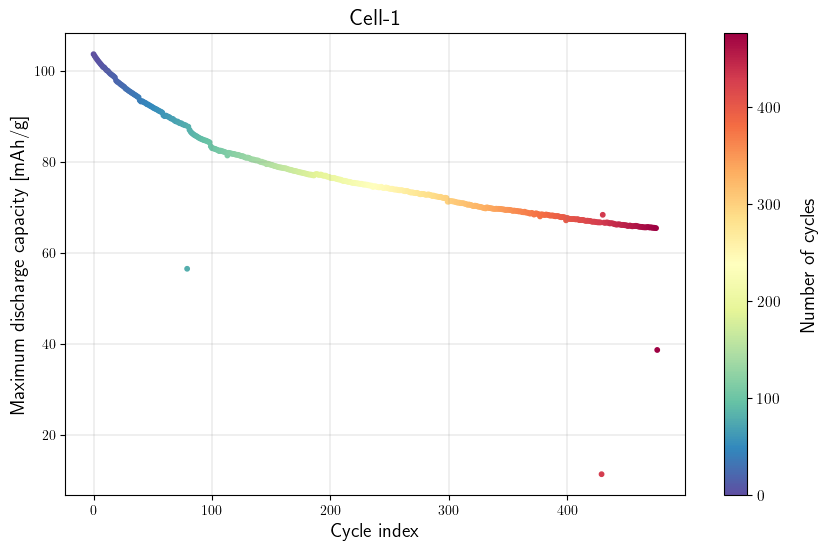

In [10]:
axplot = bviz.plot_cycle_data(
    xseries=unique_cycle_index,
    yseries=max_cap_per_cycle,
    cycle_index_series=unique_cycle_index)

axplot.set_xlabel(
    r"Cycle index",
    fontsize=14)
axplot.set_ylabel(
    r"Maximum discharge capacity [mAh/g]",
    fontsize=14)

axplot.set_title(
    f"Cell-{cell_num}",
    fontsize=16)

output_fig_filename = (
    "cycling_data_without_labels_"
    + selected_cell_label
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

# Feature transformation

In the Tohoku's dataset, we want to track the sudden and unintended capacity drop over the cycle life. Therefore, for this purpose, the features we are using are

* Cycle index
* Maximum discharge capacity
* Normalized Mahalanobis distance

## Create Xdata for Mahalanobis distance calculation

* The Mahalanobis distance is calculated from both the cycle index as well as the maximum discharge capacity.

In [11]:
df_cycle_index = pd.Series(
    unique_cycle_index,
    name="cycle_index")

# Input features for Mahalanobis distance
df_features_per_cell = pd.concat(
    [df_cycle_index,
     max_cap_per_cycle],
    axis=1)

Xfeat = df_features_per_cell.values

## Feature: Normalized Mahalanobis distance

In [12]:
# Calculate Mahalanobis distance based on cycle_index and max_discharge_capacity
cov = EmpiricalCovariance().fit(Xfeat)
mahal_dist = cov.mahalanobis(Xfeat)

df_maha_dist = pd.Series(
    mahal_dist,
    name="mahal_dist")

# Merge calculated mahalanobis distance
df_merge_features = pd.concat(
    [df_features_per_cell,
     df_maha_dist], axis=1)

# Calculate maximum mahal_dist to 
# normalize the distance calculation
max_mahal_dist = (
    df_merge_features["mahal_dist"].max())

df_merge_features["norm_mahal_dist"] = (
    df_merge_features["mahal_dist"]/max_mahal_dist)

selected_feature_cols = (
    "max_discharge_capacity",
    "norm_mahal_dist")

# Isolation Forest without hyperparameter tuning

In [13]:
# Instantiate ModelRunner with selected features and cell_label
runner = ModelRunner(
    cell_label=selected_cell_label,
    df_input_features=df_merge_features,
    selected_feature_cols=selected_feature_cols
)

## Create Xdata for training

In [14]:
# create Xdata array
Xdata = runner.create_model_x_input()

## Fit the model

In [15]:
cfg = hp.MODEL_CONFIG["iforest"]

# create model instance without hyperparameter tuning
model = cfg.baseline_model_param()
model.fit(Xdata)

# Predict probabilistic outlier score
proba = model.predict_proba(Xdata)

# Get predicted outlier cycle and score from 
# the probabilistic outlier score
(pred_outlier_indices,
 pred_outlier_score) = runner.pred_outlier_indices_from_proba(
    proba=proba,
    threshold=0.7,
    outlier_col=cfg.proba_col
)

print("Predicted anomalous cycles:")
print(pred_outlier_indices)
print("-"*70)
print("Predicted corresponding outlier score:")
print(pred_outlier_score)

Predicted anomalous cycles:
[ 79 429 476]
----------------------------------------------------------------------
Predicted corresponding outlier score:
[0.88774047 1.         0.83187098]


In [16]:
# Access the default hyperparameters without tuning
baseline_model_param = model.get_params()
pprint.pp(baseline_model_param)

{'behaviour': 'new',
 'bootstrap': False,
 'contamination': 0.1,
 'max_features': 1.0,
 'max_samples': 'auto',
 'n_estimators': 100,
 'n_jobs': -1,
 'random_state': 42,
 'verbose': 0}


# Probabilistic outliers prediction

## Predict anomalous cycles

In [17]:
df_outliers_pred = df_merge_features[
    df_merge_features["cycle_index"]
    .isin(pred_outlier_indices)].copy()

df_outliers_pred["outlier_prob"] = pred_outlier_score
df_outliers_pred

,cycle_index,max_discharge_capacity,mahal_dist,norm_mahal_dist,outlier_prob
79,79,56.489555,53.625261,0.349166,0.887740
429,429,11.293598,153.580929,1.000000,1.000000
476,476,38.625252,29.740101,0.193644,0.831871


## Probabilistic anomaly score map

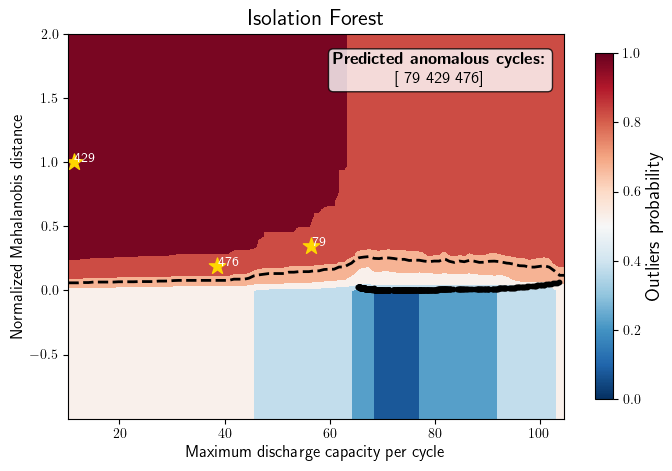

In [18]:
axplot = runner.predict_anomaly_score_map(
    selected_model=model,
    model_name="Isolation Forest",
    xoutliers=df_outliers_pred["max_discharge_capacity"],
    youtliers=df_outliers_pred["norm_mahal_dist"],
    pred_outliers_index=pred_outlier_indices,
    threshold=0.7,
    square_grid=False,
    grid_offset=1
)

axplot.set_xlabel(
    r"Maximum discharge capacity per cycle",
    fontsize=12)
axplot.set_ylabel(
    r"Normalized Mahalanobis distance",
    fontsize=12)

output_fig_filename = (
    "iforest_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

## Histogram of the anomaly score

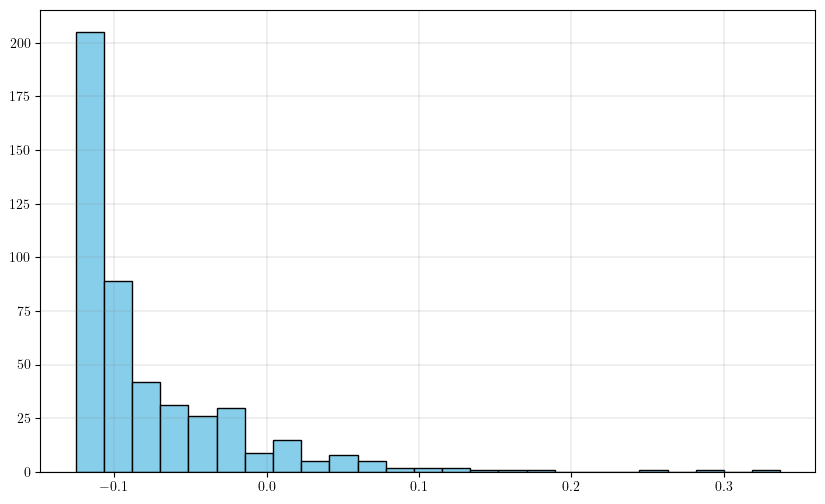

In [19]:
mpl.rcParams.update(mpl.rcParamsDefault)
rcParams["text.usetex"] = True

outlier_score = model.decision_function(Xdata)

fig, ax = plt.subplots(figsize=(10,6))

ax.hist(
    outlier_score,
    color="skyblue",
    edgecolor="black",
    bins=25)

ax.grid(
    color="grey",
    linestyle="-",
    linewidth=0.25,
    alpha=0.7)

plt.show()

In [20]:
# threshold without hyperparameter tuning
model.threshold_

np.float64(3.176712365382528e-17)

# Model performance evaluation

In [21]:
# Compare predicted probabilistic outliers against true outliers 
# from the benchamrking dataset
df_eval_outlier = modval.evaluate_pred_outliers(
    df_benchmark=df_selected_cell,
    outlier_cycle_index=pred_outlier_indices)
df_eval_outlier

,cycle_index,true_outlier,pred_outlier
0,0,0,0
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,0
...,...,...,...
472,472,0,0
473,473,0,0
474,474,0,0
475,475,0,0


## Confusion matrix

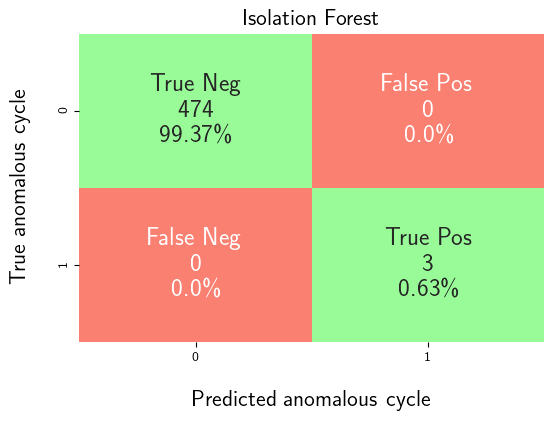

In [22]:
axplot = modval.generate_confusion_matrix(
    y_true=df_eval_outlier["true_outlier"],
    y_pred=df_eval_outlier["pred_outlier"])

axplot.set_title(
    "Isolation Forest",
    fontsize=16)

output_fig_filename = (
    "conf_matrix_iforest_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

## Evaluation metrics

In this study, we use five different metrics to evaluate the model performance:

* Accuracy
* Precision
* Recall
* F1-score
* Matthew Correlation Coefficient (MCC)

$$
\textrm{Accuracy} = \frac{\textrm{TP} + \textrm{TN}}{\textrm{Total prediction}}
$$

$$
\textrm{Precision} = \frac{\textrm{TP}}{\textrm{TP + FP}}
$$

$$
\textrm{Recall} = \frac{\textrm{TP}}{\textrm{TP + FN}}
$$

$$
\textrm{F1-score} = \frac{2(\textrm{Precision}\times \textrm{Recall})}{\textrm{Precision} + \textrm{Recall}}
$$

$$
\textrm{MCC} = \frac{TP \times TN - FP \times FN}{\sqrt{(TP + FP)(TP + FN)(TN + FP)(TN+FN)}}
$$

$$
\begin{align}
\textrm{TP} &: \textrm{True Positive} \\
\textrm{TN} &: \textrm{True Negative} \\
\textrm{FP} &: \textrm{False Positive} \\
\textrm{FN} &: \textrm{False Negative} \\
\end{align}
$$

In [23]:
df_current_eval_metrics = modval.eval_model_performance(
    model_name="iforest",
    selected_cell_label=selected_cell_label,
    df_eval_outliers=df_eval_outlier)

df_current_eval_metrics

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
MCC-score: 1.0
****************************************************************************************************


,ml_model,cell_index,accuracy,precision,recall,f1_score,mcc_score
0,iforest,cell_num_1,1.0,1.0,1.0,1.0,1.0


In [24]:
# Export current metrics to CSV
hyperparam_eval_filepath =  Path.cwd().joinpath(
    "eval_metrics_no_hp_tohoku.csv")

hp.export_current_model_metrics(
    model_name="iforest",
    selected_cell_label=selected_cell_label,
    df_current_eval_metrics=df_current_eval_metrics,
    export_csv_filepath=hyperparam_eval_filepath,
    if_exists="replace")

Have the metrics for iforest on cell cell_num_1 been evaluated before?
True
----------------------------------------------------------------------
Replacing existing row for iforest, cell_num_1.
Metrics for iforest, cell_num_1 have been replaced in the CSV file.


,ml_model,cell_index,accuracy,precision,recall,f1_score,mcc_score
0,iforest,cell_num_1,1.0,1.0,1.0,1.0,1.0
